<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Long_Term_Analysis_of_Equities_and_Gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from my_library import *

,Close
,XAU
Date,
1968-04-01,37.70
1968-04-02,37.30
1968-04-03,37.60
1968-04-04,36.95
1968-04-05,37.00
...,...
2026-02-03,4920.95
2026-02-04,4985.10


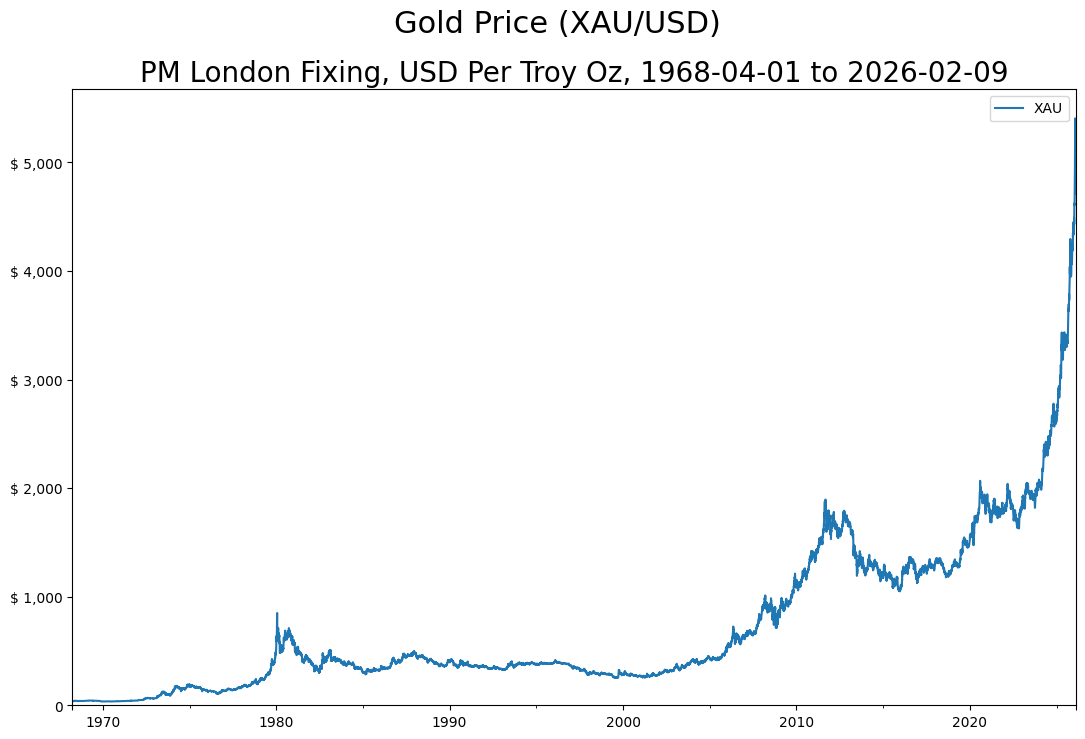

In [38]:
if 'gold' not in locals():
    gold=pd.read_json(url:="https://prices.lbma.org.uk/json/gold_pm.json")[["d","v"]].set_index("d")
    nprint("Read gold prices from %s." % url)
    gold.index=pd.DatetimeIndex(gold.index).to_period('B')
    gold.index.name='Date'
    gold[('Close',alternative:='XAU')]=gold['v'].apply(lambda x:x[0])
    gold.drop('v',axis=1,inplace=True)
    gold.columns=pd.MultiIndex.from_tuples(gold.columns)

display(gold)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
gold['Close'].plot(ax=plot)
figure.suptitle(title:='Gold Price (XAU/USD)',fontsize=22)
plot.set_title(subtitle:='PM London Fixing, USD Per Troy Oz, %s to %s' % (gold.index[0],gold.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title.replace("/","-")+".png",dpi=300,bbox_inches='tight')

,Discount Rate,Days,Return,Close
,DTB3,,,DTB3
Date,,,,
1954-01-04,1.33,0,NaN,1000.000000
1954-01-05,1.28,1,0.003694,1000.036944
1954-01-06,1.28,2,0.003556,1000.072501
1954-01-07,1.31,3,0.003556,1000.108059
1954-01-08,1.31,4,0.003639,1000.144452
...,...,...,...,...
2026-02-02,3.60,26327,0.029833,21493.531064
2026-02-03,3.60,26328,0.010000,21495.680417


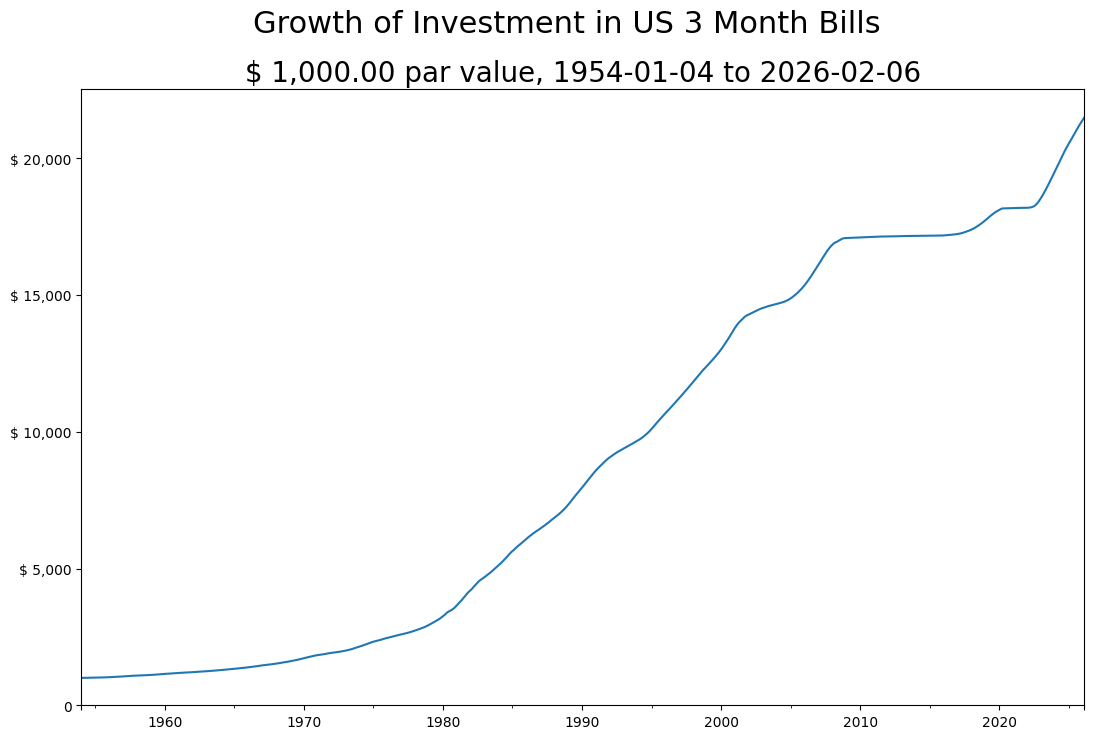

In [39]:
if 'bills' not in locals():
    bills=get_fred(n:='DTB3')[0]
    nprint("Read Three Month Bills Rate from FRED.")
    bills.index.name='Date'
    bills.columns=pd.MultiIndex.from_tuples([('Discount Rate',n)])
    bills['Days']=list(map(lambda x:(x-bills.index[0]).n,bills.index))
    bills['Return']=bills[('Discount Rate',n)].shift()/360e0*bills['Days'].diff()
    bills[('Close',n)]=(par:=1e3)*(one+bills['Return']/hundred).cumprod()
    bills.loc[bills.index[0],('Close',n)]=par
    bills.index=bills.index.to_timestamp().to_period('B')

display(bills)

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
bills[('Close',n)].plot(ax=plot)
figure.suptitle(title:='Growth of Investment in US 3 Month Bills',fontsize=22)
plot.set_title(subtitle:='$ {:,.2f} par value, {:s} to {:s}'.format(par,str(bills.index[0]),str(bills.index[-1])),fontsize=20)
plot.set_xlabel(None)
plot.yaxis.set_major_formatter(CurrencyLabels(0))
plot.set_ylim(zero,None)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

Ticker: ^GSPC


[*********************100%***********************]  1 of 1 completed

18:05:34 Read ^GSPC data from Yahoo Finance.



/tmp/ipython-input-3720515859.py:4: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.DatetimeIndex(data.index).to_period('B')
/tmp/ipython-input-3720515859.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred


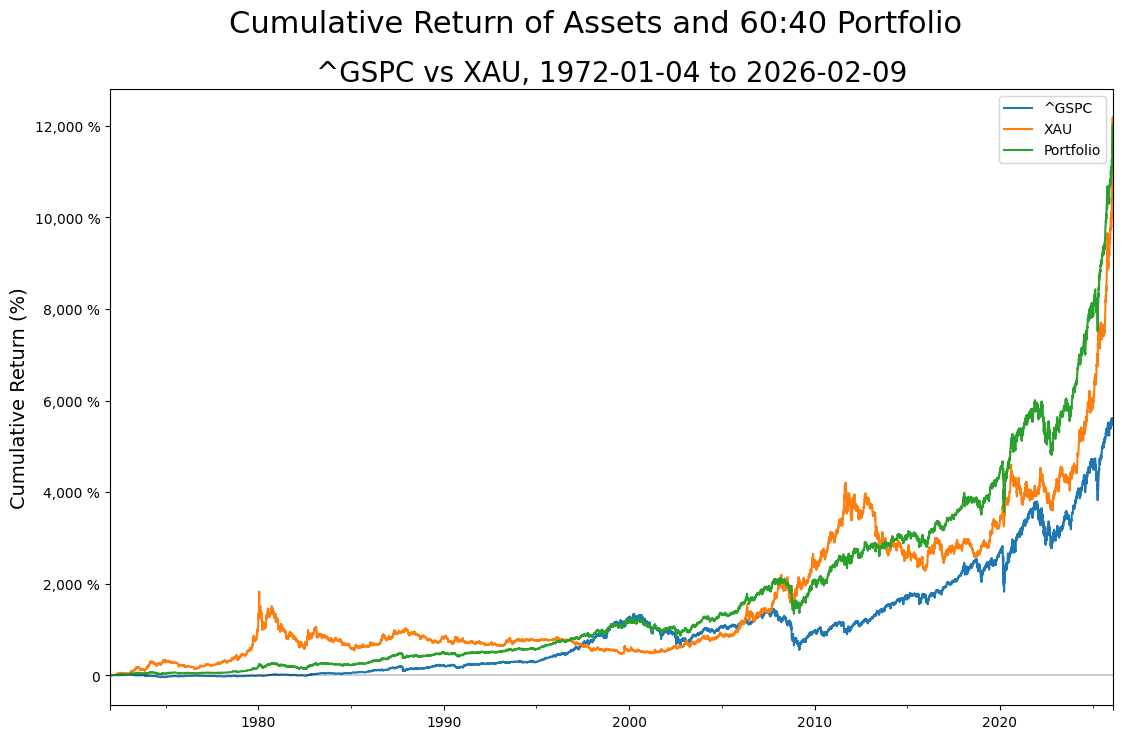

In [40]:
data=download(market:=input('Ticker: '),"1972-01-01",today("%Y-%m-%d"),auto_adjust=True)
nprint("Read %s data from Yahoo Finance." % market)
tickers=[market,alternative:='XAU']
data.index=pd.DatetimeIndex(data.index).to_period('B')
data[('Close',alternative)]=gold[('Close',alternative)] if alternative=='XAU' else bills[('Close',alternative)]
data.columns=pd.MultiIndex.from_tuples(data.columns)
#data=data.resample('M').last()

for ticker in tickers:
    data[('Return',ticker)]=data[('Close',ticker)].pct_change()*hundred
    data[('Weight',ticker)]=0.6 if ticker==market else 0.4

data.dropna(inplace=True)
data.sort_index(axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

for ticker in tickers+['Portfolio']:
    data[('Cumulative',ticker)]=(data[('Return',ticker)]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and 60:40 Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [41]:
from warnings import filterwarnings ; filterwarnings('ignore',category=pd.errors.PerformanceWarning)

report=pd.DataFrame({'Weight':np.arange(zero,one+(delta:=0.025),delta)}).set_index("Weight")

if data.index.dtype==pd.PeriodDtype('W'):
    annualize=52e0

elif data.index.dtype==pd.PeriodDtype('M'):
    annualize=12e0

elif data.index.dtype==pd.PeriodDtype('Q'):
    annualize=4e0

elif data.index.dtype==pd.PeriodDtype('Y'):
    annualize=1e0

else:
    annualize=252e0

nprint("Finding optimal portfolio by grid search.")

for weight in tqdm(report.index):
    report.loc[weight,market]=weight
    report.loc[weight,alternative]=one-weight

    for ticker in tickers:
        data[('Weight',ticker)]=report.loc[weight,ticker]

    data.drop(('Return','Portfolio'),axis=1,inplace=True)
    data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)

    report.loc[weight,'Sample']=(r:=data[('Return','Portfolio')]).count()
    report.loc[weight,'Mean']=(m:=r.mean())
    report.loc[weight,'Std.Dev.']=(s:=r.std())
    report.loc[weight,'Std.Err.']=r.sem()
    report.loc[weight,'Kurtosis']=r.kurt()+three

report['Sharpe']=report['Mean']/report['Std.Dev.']*annualize**half
report['Sharpe S.E.']=((annualize/report['Sample'])*(one+(report['Kurtosis']-one)/four*report['Sharpe']**two))**half
report['Annualized']=hundred*(one+report['Mean']/hundred)**annualize-hundred

display(report)

18:05:44 Finding optimal portfolio by grid search.


  0%|          | 0/41 [00:00<?, ?it/s]

,^GSPC,XAU,Sample,Mean,Std.Dev.,Std.Err.,Kurtosis,Sharpe,Sharpe S.E.,Annualized
Weight,,,,,,,,,,
0.000,0.000,1.000,13310.0,0.043500,1.256264,0.010889,13.309906,0.549674,0.191149,11.582644
0.025,0.025,0.975,13310.0,0.043322,1.224881,0.010617,13.321579,0.561453,0.193178,11.532681
0.050,0.050,0.950,13310.0,0.043144,1.194139,0.010351,13.321483,0.573544,0.195238,11.482740
0.075,0.075,0.925,13310.0,0.042966,1.164088,0.010090,13.307562,0.585925,0.197313,11.432822
0.100,0.100,0.900,13310.0,0.042788,1.134785,0.009836,13.277701,0.598568,0.199385,11.382926
0.125,0.125,0.875,13310.0,0.042611,1.106288,0.009589,13.229815,0.611435,0.201431,11.333052
0.150,0.150,0.850,13310.0,0.042433,1.078661,0.009350,13.161987,0.624479,0.203427,11.283201
0.175,0.175,0.825,13310.0,0.042255,1.051972,0.009118,13.072655,0.637639,0.205345,11.233371
0.200,0.200,0.800,13310.0,0.042077,1.026296,0.008896,12.960840,0.650841,0.207158,11.183564


In [42]:
s1,s12,s12,s2=data['Return'][tickers].cov().to_numpy().reshape(4)
w1=(s2**2-s12)/(s1**2+s2**2-two*s12)
w2=one-w1
nprint("Mean-Variance Optimal Fully Invested Portfolio is %.0f:%0.f." % (w1*hundred,w2*hundred))

18:11:11 Mean-Variance Optimal Fully Invested Portfolio is 64:36.


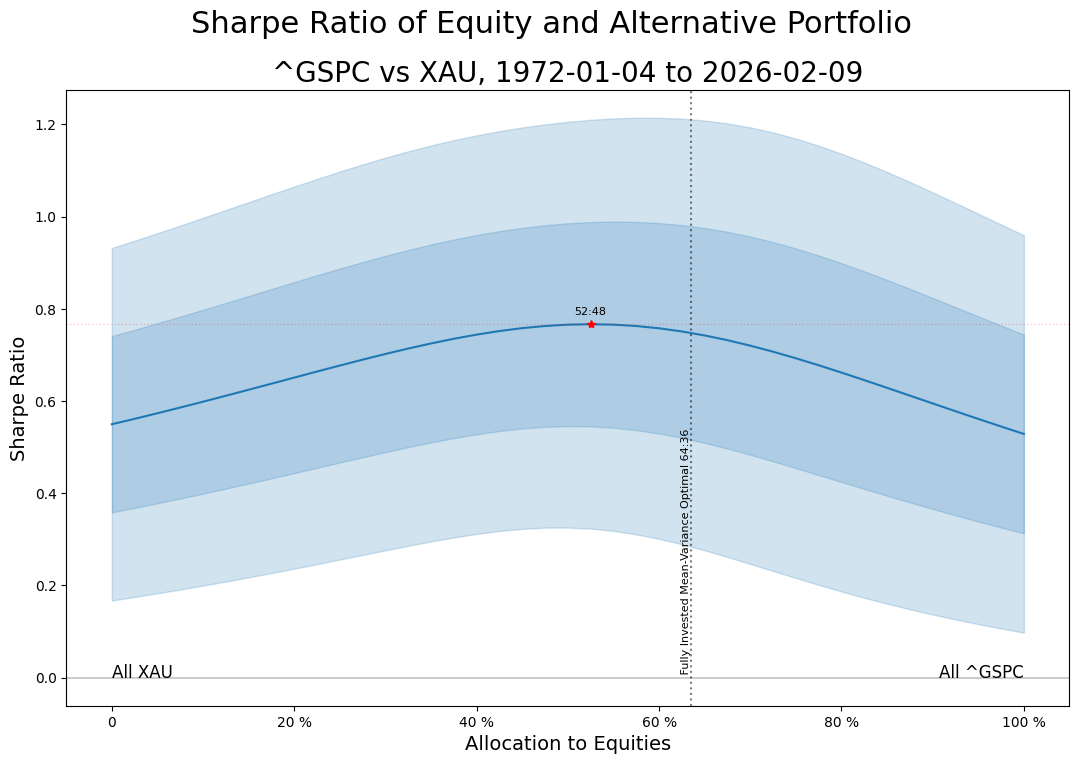

In [43]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index.to_numpy())*hundred,y:=report.loc[x,'Sharpe'].to_numpy())
plot.fill_between(x*hundred,y+(ye:=report.loc[x,'Sharpe S.E.']),y-ye,color='C0',alpha=0.2)
plot.fill_between(x*hundred,y+two*ye,y-two*ye,color='C0',alpha=0.2)
figure.suptitle(title:='Sharpe Ratio of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Sharpe Ratio',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[(omega:=y.argmax())]*hundred,y[omega],'r*')
plot.text(x[omega]*hundred,y[omega]*1.02,'%.0f:%.0f' % (x[omega]*hundred,hundred-x[omega]*hundred),fontsize=8,ha='center',va='bottom')
plot.axhline(y[omega],color='red',linestyle=':',linewidth=1,alpha=0.2)
plot.axvline(w1*hundred,color='black',linestyle=':',alpha=0.5)
plot.text(w1*hundred,zero,' Fully Invested Mean-Variance Optimal %.0f:%0.f' % (w1*hundred,w2*hundred),rotation=90,ha='right',va='bottom',fontsize=8)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

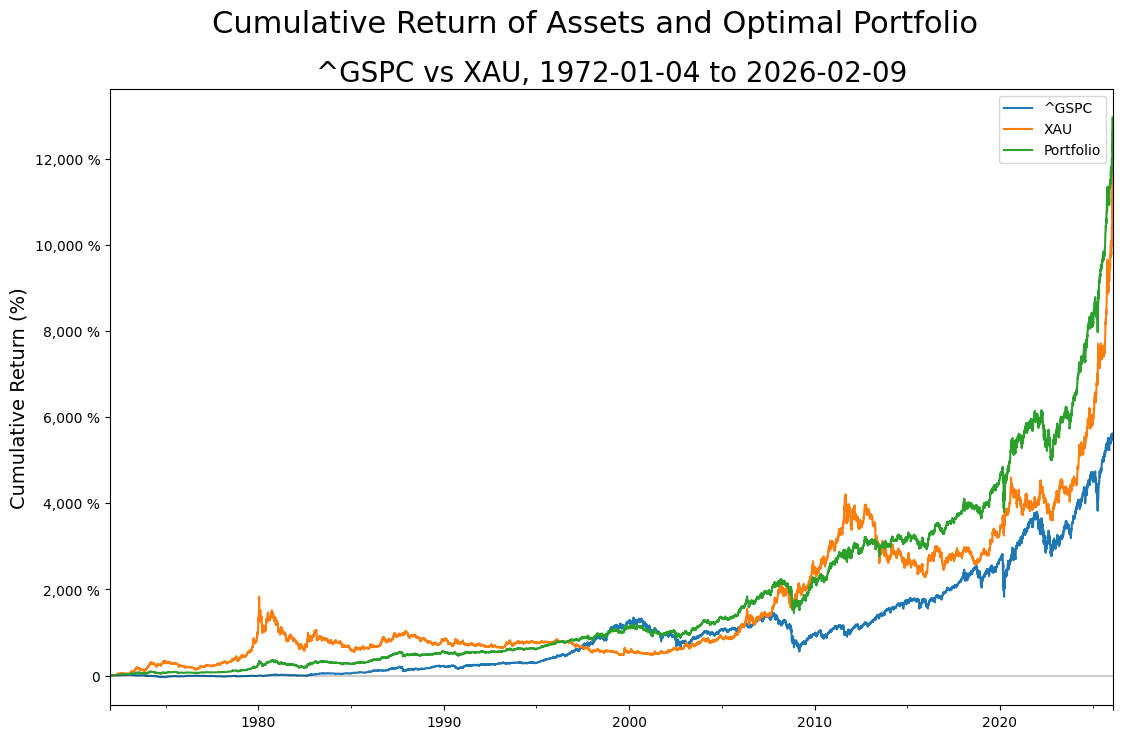

In [44]:
weight=x[omega]

for ticker in tickers:
    data[('Weight',ticker)]=report.loc[weight,ticker]

data.drop(('Return','Portfolio'),axis=1,inplace=True)
data[('Return','Portfolio')]=data.apply(lambda x:np.sum(x[('Weight',)]*x[('Return',)]),axis=1)
data[('Cumulative','Portfolio')]=(data[('Return','Portfolio')]/hundred+one).cumprod()*hundred-hundred

figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
data['Cumulative'].plot(ax=plot)
figure.suptitle(title:='Cumulative Return of Assets and Optimal Portfolio',fontsize=22)
plot.set_title(subtitle:="%s, %s to %s" % (" vs ".join(tickers),data.index[0],data.index[-1]),fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Cumulative Return (%)',fontsize=14)
plot.yaxis.set_major_formatter(PercentLabels(0))
plot.axhline(color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

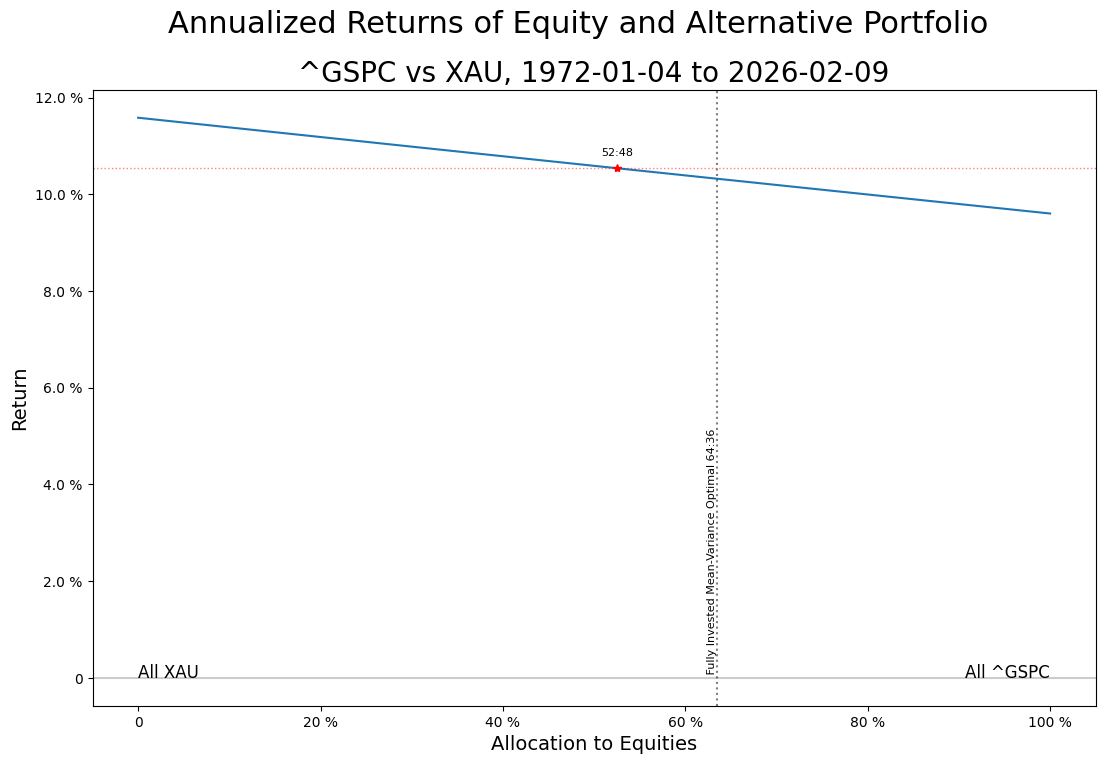

In [45]:
figure,plot=pl.subplots(figsize=(8*GoldenRatio,8))
plot.plot((x:=report.index.to_numpy())*hundred,y:=report.loc[x,'Annualized'].to_numpy())
figure.suptitle(title:='Annualized Returns of Equity and Alternative Portfolio',fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel('Allocation to Equities',fontsize=14)
plot.set_ylabel('Return',fontsize=14)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.yaxis.set_major_formatter(PercentLabels(1))
plot.text(zero,zero,"All "+alternative,fontsize=12,horizontalalignment='left')
plot.text(hundred,zero,"All "+market,fontsize=12,horizontalalignment='right')
plot.axhline(color='black',alpha=0.2)
plot.plot(x[omega]*hundred,y[omega],'r*')
plot.text(x[omega]*hundred,y[omega]*1.02,'%.0f:%.0f' % (x[omega]*hundred,hundred-x[omega]*hundred),fontsize=8,ha='center',va='bottom')
plot.axvline(w1*hundred,color='black',linestyle=':',alpha=0.5)
plot.text(w1*hundred,zero,' Fully Invested Mean-Variance Optimal %.0f:%0.f' % (w1*hundred,w2*hundred),rotation=90,ha='right',va='bottom',fontsize=8)
plot.axhline(y[omega],color='red',linestyle=':',linewidth=1,alpha=0.5)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')